<a href="https://colab.research.google.com/github/Servat0r/ISPR-Midterms-2023/blob/master/Midterm2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Midterm 2 ISPR 2023 - Assignment 2 - Salvatore Correnti (matr. 584136)
In this assignment we will implement and test a simple image understanding application based on the `Latent Dirichlet Allocation` model applied to images.

## Initial Imports
As in the first assignment, before any coding we reserve a couple of cells for changing working directory and for all needed imports.

In [2]:
%cd "/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023"

/content/drive/MyDrive/Colab Notebooks/ISPR-Midterms-2023


In [3]:
import numpy as np
from sklearn.cluster import KMeans
import cv2
import os
from PIL import Image
from typing import *
import math
import matplotlib.pyplot as plt
from time import perf_counter
from gensim.models.ldamodel import LdaModel as LDA

## Latent Dirichlet Allocation for Image Understanding
`Latent Dirichlet Allocation (LDA)` is a generative model that is used for discovering categories (called `topics`) from a set of `documents` composed of `words` and to classify those documents mixtures of those topics with one `"main" topic`.

The terms `documents`, `words` and `topics` come from the fact that this model has been used mainly in the field of `Natural Language Processing` for document classification and tagging, using text corpora as training data, since this model is well suited for dealing with `atomic` units that have a semantic and appear in multiple documents.

In this notebook we will implement and test a simple application of `LDA` to the field of `Computer Vision`, in particular for `Image Understanding`.

### Latent Dirichlet Allocation
TODO: Brief description of LDA

### Bag of Visual Words Model
TODO: Description of BOVW Model

#### 0.    Utility Functions
Before proceeding in the implementation of `BOVW` model, we define some utilities for operating with images.

In [4]:
def pil_load_image(dir_path: str, file_name: str, to_grayscale=False) -> Image.Image:
  pil_image = Image.open(os.path.join(dir_path, file_name))
  return pil_image.convert('L') if to_grayscale else pil_image

def cv2_load_image(dir_path: str, file_name: str, to_grayscale=False) -> np.ndarray:
  cv2_image = cv2.imread(os.path.join(dir_path, file_name))
  if (len(cv2_image.shape) > 1) and to_grayscale:
    return cv2.cvtColor(cv2_image, cv2.COLOR_BGR2GRAY)
  else:
    return cv2_image

In [5]:
def cv2_to_pil(img_array: np.ndarray):
  mode = cv2.COLOR_BGR2RGB if len(img_array.shape) == 3 else None
  if mode is not None:
    pil_img_array = cv2.cvtColor(img_array, mode)
  else:
    pil_img_array = img_array
  pil_img = Image.fromarray(pil_img_array)
  return pil_img, pil_img_array

def pil_to_cv2(img: Union[Image.Image, np.ndarray]):
  img_array = np.asarray(img) if isinstance(img, Image.Image) else img
  mode = cv2.COLOR_RGB2BGR if len(img_array.shape) == 3 else None
  if len(img_array.shape) == 3: #mode is not None:
    print('nia')
    cv2_img_array = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
  else:
    cv2_img_array = img_array
  return cv2_img_array

Finally, for plotting results on multiple rows/columns:

In [6]:
def plot_results(
    images: Union[Image.Image, list[Image.Image]],
    show=True, figsize_scale_factor=1,
    images_per_row=None, images_per_column=None,
  ):
  if isinstance(images, Image.Image):
    images = [images]
  if (images_per_row is None) or (images_per_column is None):
    images_per_row, images_per_column = len(images), 1
  elif (images_per_row * images_per_column != len(images)):
    raise ValueError(
      f"Mismatch between (images_per_row = {images_per_row}, " \
      f"images_per_column = {images_per_column}) and len(images): " \
      f"{images_per_row * images_per_column} vs {len(images)}"
    )
  n = len(images)
  # (6.4, 4.8) are the default values for figsize in matplotlib
  figsize = (figsize_scale_factor * 6.4, figsize_scale_factor * 4.8)
  fig, ax = plt.subplots(images_per_column, images_per_row, figsize=figsize)
  if n == 1:
    ax = np.array([ax]).reshape((1, 1))  # Uniforming with the case of n > 1
  if len(ax.shape) == 1:
    ax = np.reshape(ax, (1, len(ax)))
  for i in range(images_per_column):
    for j in range(images_per_row):
      ax[i, j].imshow(images[i * images_per_row + j], interpolation='nearest', cmap='gray')
      ax[i, j].plot()
  if show:
    plt.show()

In [7]:
def count_occurrencies(data: np.ndarray, end=None, start=0, repr_type='sparse'):
  end = end if end is not None else len(data)
  if repr_type == 'dense':
    results = np.zeros(end, dtype=np.intc)
    for i in range(start, end):
      results[i] = len(data[data == i])
  elif repr_type == 'sparse':
    results = []
    for i in range(start, end):
      results.append(
          (start + i, len(data[data == i]))
      )
  else:
    raise ValueError(f"Unknown representation type '{repr_type}'")
  return results

In [8]:
def draw_samples(
    prob_dists: np.ndarray, samples_per_dist: Union[int, list[int]]=1, seed=None
):
  # Handle cases in which samples_per_dist is a number or a list
  N = len(prob_dists)
  max_samples_per_dist = samples_per_dist \
  if isinstance(samples_per_dist, int) else max(samples_per_dist)
  samples_per_dist = N * [samples_per_dist] \
  if isinstance(samples_per_dist, int) else samples_per_dist

  # Now draw samples
  rng = np.random.default_rng(seed)
  samples = np.full((N, max_samples_per_dist), -1, dtype=np.intc)
  num_items = prob_dists.shape[1]
  for i in range(N):
    samples[i] = rng.choice(num_items, size=max_samples_per_dist, p=prob_dists[i])
    samples[i][samples_per_dist[i]:] = -1
  return samples

#### 1. SIFT Feature Extraction
We will use the implementation of `SIFT` feature extractor available in `OpenCV` to detect **both** *interest points* and their *descriptors*.

In [9]:
def apply_sift(img_array: np.ndarray):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints, descriptors = sift.detectAndCompute(img_array, None)
  return keypoints, descriptors

We add a bit of complexity for handling colors when dealing with arbitrary numbers of keypoint categories.

In [72]:
DEFAULT_COLORS = [
    (0, 0, 0), (0, 0, 255), (0, 255, 0), (255, 0, 0), (0, 255, 255),                # black, red, green, blue, cyan
    (255, 165, 0), (255, 192, 203), (128, 0, 128), (165, 42, 42), (64, 224, 208),   # orange, pink, purple, brown, turquoise
    (128, 128, 128), (255, 0, 255), (230, 230, 230), (128, 0, 0), (0, 0, 128),      # gray, magenta, lavender, maroon, navy
    (0, 128, 128), (128, 128, 0), (255, 218, 185), (210, 180, 140), (245, 245, 220) # teal, olive, peach, tan, beige
]

_COLOR_CONST = 16

def _generate_color(b_idx, g_idx, r_idx):
  return (b_idx * (256//_COLOR_CONST), g_idx * (256//_COLOR_CONST), r_idx * (256//_COLOR_CONST))

def _generate_colors(max_class_id):
  if (max_class_id > (256//_COLOR_CONST)**3):
    raise OverflowError(f"Cannot generate colors for a value {max_class_id} > {_COLOR_CONST**3}")
  red_idx = max_class_id % _COLOR_CONST
  green_idx = (max_class_id // _COLOR_CONST) % _COLOR_CONST
  blue_idx = (max_class_id // _COLOR_CONST) // _COLOR_CONST
  colors = []
  for i in range(blue_idx+1):
    for j in range(_COLOR_CONST):
      for k in range(_COLOR_CONST):
        j_valid = (i < blue_idx) or (j <= green_idx)
        k_valid = (i < blue_idx) or (j < green_idx) or (k < red_idx)
        if not (j_valid and k_valid):
          continue
        colors.append(_generate_color(i, j, k))
  return colors

def draw_keypoints(img_array: np.ndarray, keypoints, class_ids=False, max_class_id=None, colors=None, **kwargs):
  if class_ids:
    if (max_class_id is None) or not (isinstance(max_class_id, int)) or (max_class_id < 0):
      raise ValueError(f"If class_ids=True, max_class_id must be an integer >= 0 (found '{max_class_id}')")
    if colors is None:
      use_defaults = (max_class_id <= len(DEFAULT_COLORS))
      colors = DEFAULT_COLORS if use_defaults else _generate_colors(max_class_id)
      if not use_defaults:
        np.random.shuffle(colors)
    elif len(colors) < max_class_id:
      colors = _generate_colors(max_class_id)
      np.random.shuffle(colors)
    for i in range(max_class_id):
      id_kp = [keypoint for keypoint in keypoints if keypoint.class_id == i]
      if len(id_kp) > 0:
        img_array = cv2.drawKeypoints(img_array, id_kp, None, colors[i], **kwargs)
    return img_array, colors
  else:
    return cv2.drawKeypoints(img_array, keypoints, None, **kwargs), colors

And now an example:

(125, 128)


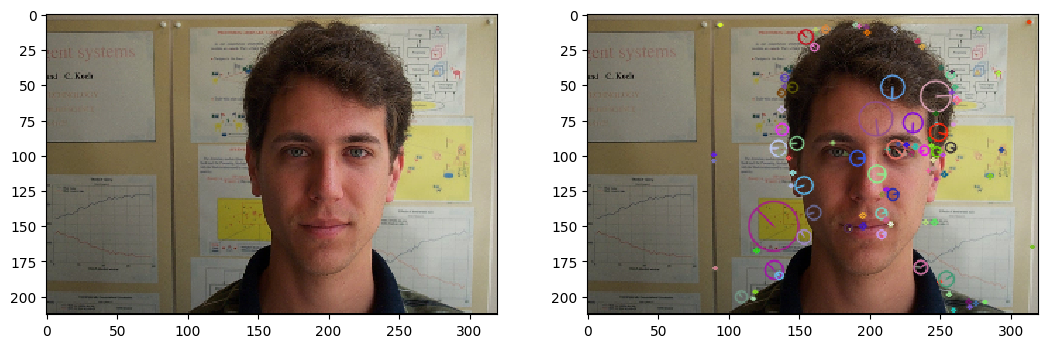

In [11]:
dir_path = 'MSRC_ObjCategImageDatabase_v1'
file_name = '6_4_s.bmp'
# Load images
pil_rgb_image = pil_load_image(dir_path, file_name)
cv2_bgr_image = cv2_load_image(dir_path, file_name)
cv2_gray_image = cv2.cvtColor(cv2_bgr_image, cv2.COLOR_BGR2GRAY)
# Extract features
keypoints, descriptors = apply_sift(cv2_gray_image)
print(descriptors.shape)
# Draw keypoints and convert to PIL
cv2_bgr_image_keypoints, _ = draw_keypoints(cv2_bgr_image, keypoints, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
pil_rgb_image_keypoints, _ = cv2_to_pil(cv2_bgr_image_keypoints)
# Show original and keypoints images
plot_results(
    [pil_rgb_image, pil_rgb_image_keypoints], figsize_scale_factor=2,
)

#### 2. Dataset
We will use the same dataset as in `Midterm 1`:

http://download.microsoft.com/download/A/1/1/A116CD80-5B79-407E-B5CE-3D5C6ED8B0D5/msrc_objcategimagedatabase_v1.zip

In this case we will use the whole dataset for training and testing. Since we want to have *reproducible* experiments, we will implement a sampling procedure from the whole dataset s.t. we can pass a seed to *always* get the *same* dataset each time we run this notebook.

In [12]:
def train_test_split(
    dir_path: str, test_images_per_category: int = 1,
    random_state: Union[int, None] = None,
):
  filenames = os.listdir(dir_path)
  filenames = [filename for filename in filenames if ('GT' not in filename) and ('bmp' in filename)]
  filenames_by_category = {str(i): [] for i in range(1, 9)}
  for filename in filenames:
    filenames_by_category[filename[0]].append(filename)

  for k, v in filenames_by_category.items():
    filenames_by_category[k] = sorted(v, key=lambda x: int(x.split('_')[1]))

  rng = np.random.default_rng(random_state)

  train_images = []
  test_images = []

  for i in range(test_images_per_category):
    indexes = rng.integers(30-i, size=8)
    for j in range(1, 9):
      v = filenames_by_category[str(j)]
      test_images.append(v.pop(indexes[j-1]))

  for i in range(1, 9):
    train_images += filenames_by_category[str(i)]
  
  return train_images, test_images

#### 3. Building the codebook
The next step is to build a `codebook` from the SIFT descriptors extracted from training images. A `codebook` is a vocabulary that indexes visual words such that each SIFT descriptor can be assigned a word in the codebook itself. In other terms, we will *cluster* the SIFT descriptors extracted from the training images into $k$ clusters and our codebook will contain a representative word for each of the $k$ clusters.

In our case, we will use `KMeans` as clustering algorithm and we will save each of the $k$ `centroids` found by KMeans as representative words.

In [13]:
class Codebook:
  def __init__(
      self, dir_path, train_images_filenames: list[str],
      n_clusters=10, max_iter=1000,
  ):
    cv2_gray_images = [
      cv2_load_image(dir_path, train_image_filename, to_grayscale=True)
      for train_image_filename in train_images_filenames
    ]
    # SIFT descriptors
    sift_outputs = [apply_sift(img_array) for img_array in cv2_gray_images]
    # Descriptors for all images
    image_descriptors = [sift_output[1] for sift_output in sift_outputs]
    # Keypoints for all images
    self.image_keypoints = [sift_output[0] for sift_output in sift_outputs]
    # |descriptors| for each image
    self.image_descriptors_lengths = [len(image_descriptor) for image_descriptor in image_descriptors]
    self.num_images = len(image_descriptors)
    self.image_descriptors = np.row_stack(image_descriptors)
    self.n_clusters = n_clusters
    kmeans = KMeans(n_clusters, max_iter=max_iter).fit(self.image_descriptors)
    self._kmeans = kmeans
    # Rewrite the labels in "proper" way
    self._labels = self._adapt_labels(self._kmeans.labels_, self.image_descriptors_lengths)
    # Set class id for all keypoints
    self._set_keypoints_labels(self.image_keypoints, self.labels)
  
  @staticmethod
  def _adapt_labels(labels: list[int], lengths: list[int]) -> list[np.ndarray]:
    result = []
    num_images = len(lengths)
    for i in range(num_images):
      start_index = sum(lengths[:i])
      result.append(
        np.array([labels[start_index+j] for j in range(lengths[i])], dtype=np.intc)
      )
    return result
  
  @staticmethod
  def _set_keypoints_labels(keypoints, labels):
    for keypoints_list, labels_list in zip(keypoints, labels):
      for keypoint, label in zip(keypoints_list, labels_list):
        keypoint.class_id = label
  
  @property
  def labels(self):
    return self._labels
  
  @property
  def cluster_centers(self):
    return self._kmeans.cluster_centers_
  
  def get_cluster_centers(self, values: np.ndarray):
    return self.cluster_centers[self.get_cluster_indexes(values)]
  
  def get_cluster_indexes(self, values: np.ndarray):
    return [self._kmeans.predict(value) for value in values]

  # Return the Bag Of Visual Words representation for training images
  def get_training_bovw_representation(self) -> list[list[tuple[int, int]]]:
    results = []
    for i in range(self.num_images):
      results.append(count_occurrencies(self.labels[i], self.n_clusters))
    return results
  
  def get_test_bovw_representation(self, cv2_gray_images_arrays: np.ndarray):
    num_images = len(cv2_gray_images_arrays)
    sift_outputs = [
        apply_sift(cv2_gray_images_array) 
        for cv2_gray_images_array in cv2_gray_images_arrays
    ]
    keypoints = [sift_output[0] for sift_output in sift_outputs]
    descriptors = [sift_output[1] for sift_output in sift_outputs]
    indexes = self.get_cluster_indexes(descriptors)
    results = []
    for i in range(num_images):
      results.append(count_occurrencies(indexes[i], self.n_clusters))
    # Now set cluster values for all keypoints
    self._set_keypoints_labels(keypoints, indexes)
    return indexes, results, keypoints
  
  @staticmethod
  def to_dense(sparse_list: list[tuple[int, Any]]):
    return [val for idx, val in sparse_list]

In [14]:
crt = perf_counter()
dir_path = 'MSRC_ObjCategImageDatabase_v1'
N_CLUSTERS = 1000
train_images_filenames, test_images_filenames = train_test_split(
    dir_path, random_state=0,
)
codebook = Codebook(dir_path, train_images_filenames, N_CLUSTERS, 10_000)
crt = perf_counter() - crt
print(f"Elapsed time: {crt:.4f} seconds")

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Elapsed time: 873.4009 seconds


We can now calculate a histogram-like representation for each of the categories we have detected with `KMeans` for each training image, visualize raw values and plot histograms for some images.

In [64]:
def plot_bovw_images(
    bovw_repr: list[list[tuple[int, int]]], labels: list[list[int]],
    dir_path: str, images_filenames: list[str], keypoints, n_classes: int,
    nrows: int, figsize=(6.4, 4.8), show=True, verbose=True,
):
  fig, ax = plt.subplots(nrows, 2, figsize=figsize)
  if nrows == 1:
    ax = ax.reshape((1, 2))
  for i in range(len(bovw_repr)):
    if verbose:
      print(f"BOVW representation values: {bovw_repr[i]}")
    pil_image = pil_load_image(dir_path, images_filenames[i])
    cv2_bgr_image = cv2_load_image(dir_path, images_filenames[i])
    cv2_bgr_image, colors = draw_keypoints(
        cv2_bgr_image, keypoints[i], True,
        n_classes, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )
    pil_kp_image, _ = cv2_to_pil(cv2_bgr_image)
    #ax[i, 0].imshow(pil_image, interpolation='nearest', cmap='gray')
    ax[i, 0].imshow(pil_kp_image, interpolation='nearest', cmap='gray')
    ax[i, 1].hist(labels[i], np.arange(0, n_classes+1, 1), rwidth=1.0)
  if show:
    plt.show()

BOVW representation values: [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 1), (8, 1), (9, 0), (10, 0), (11, 0), (12, 0), (13, 0), (14, 1), (15, 0), (16, 0), (17, 0), (18, 0), (19, 0), (20, 2), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 0), (28, 0), (29, 0), (30, 0), (31, 0), (32, 0), (33, 0), (34, 0), (35, 0), (36, 3), (37, 2), (38, 0), (39, 0), (40, 0), (41, 0), (42, 0), (43, 0), (44, 0), (45, 0), (46, 0), (47, 0), (48, 0), (49, 0), (50, 0), (51, 0), (52, 0), (53, 0), (54, 0), (55, 0), (56, 0), (57, 1), (58, 0), (59, 1), (60, 0), (61, 0), (62, 0), (63, 1), (64, 0), (65, 0), (66, 1), (67, 0), (68, 0), (69, 0), (70, 0), (71, 0), (72, 3), (73, 0), (74, 0), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 3), (81, 0), (82, 3), (83, 1), (84, 0), (85, 0), (86, 0), (87, 2), (88, 1), (89, 0), (90, 3), (91, 0), (92, 2), (93, 1), (94, 0), (95, 0), (96, 1), (97, 0), (98, 1), (99, 0), (100, 0), (101, 0), (102, 0), (103, 0), (104, 0), (105, 0), (106, 3), (107, 2), (

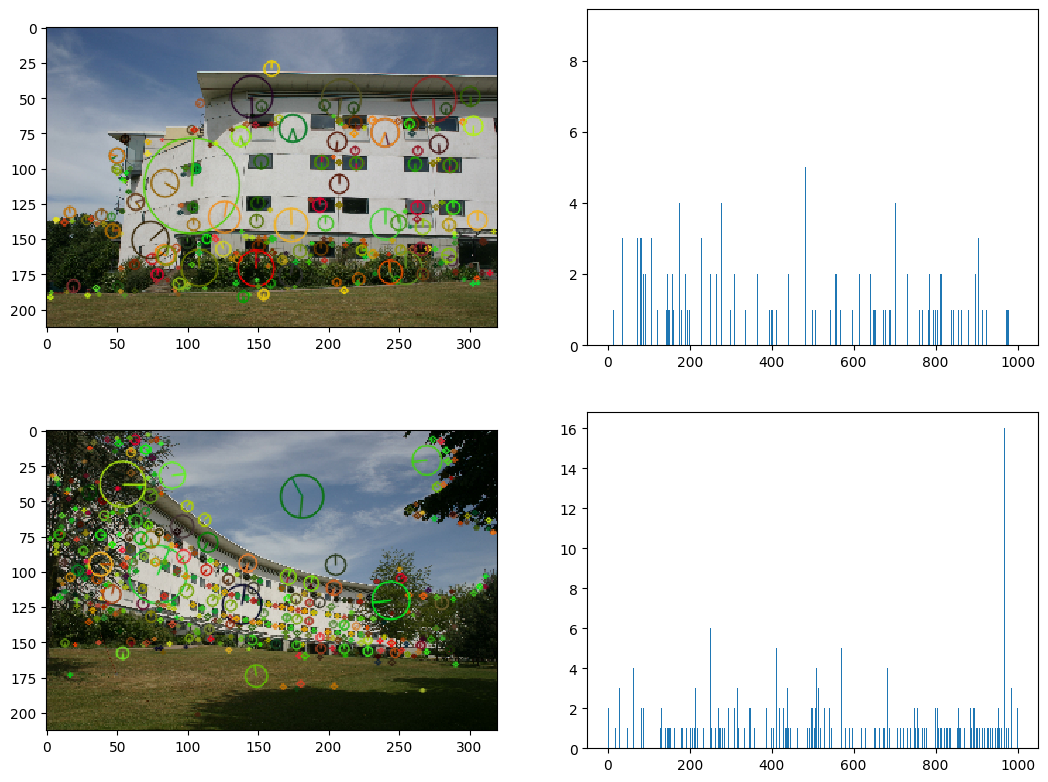

In [67]:
N_IMAGES = 2
START = 80
train_bovw_representation = codebook.get_training_bovw_representation()
plot_bovw_images(
    train_bovw_representation[START:START+N_IMAGES],
    codebook.labels[START:START+N_IMAGES],
    dir_path, train_images_filenames[START:START+N_IMAGES],
    codebook.image_keypoints[START:START+N_IMAGES],
    n_classes=N_CLUSTERS, nrows=N_IMAGES, figsize=(12.8, 9.6), show=True,
)

#### 4. Test the KMeans for new images
We now need to test that the `codebook` is capable of giving this `BOVW` representation also for new images. In the `Codebook` class, we have implemented the `get_cluster_indexes()` method, which will convert a matrix of SIFT descriptors into the corresponding cluster centers indexes. Let's test it with a few test images:

BOVW representation values: [(0, 1), (1, 2), (2, 0), (3, 1), (4, 0), (5, 0), (6, 0), (7, 0), (8, 3), (9, 0), (10, 3), (11, 3), (12, 0), (13, 1), (14, 0), (15, 0), (16, 1), (17, 0), (18, 0), (19, 0), (20, 0), (21, 0), (22, 0), (23, 0), (24, 0), (25, 0), (26, 0), (27, 3), (28, 0), (29, 0), (30, 1), (31, 0), (32, 2), (33, 0), (34, 1), (35, 0), (36, 0), (37, 2), (38, 2), (39, 0), (40, 0), (41, 1), (42, 0), (43, 1), (44, 0), (45, 2), (46, 0), (47, 2), (48, 3), (49, 0), (50, 1), (51, 0), (52, 0), (53, 1), (54, 0), (55, 1), (56, 0), (57, 1), (58, 1), (59, 0), (60, 0), (61, 0), (62, 0), (63, 1), (64, 1), (65, 1), (66, 2), (67, 1), (68, 1), (69, 0), (70, 0), (71, 0), (72, 0), (73, 0), (74, 3), (75, 0), (76, 0), (77, 0), (78, 0), (79, 0), (80, 0), (81, 0), (82, 2), (83, 0), (84, 0), (85, 1), (86, 0), (87, 0), (88, 0), (89, 0), (90, 0), (91, 0), (92, 0), (93, 0), (94, 0), (95, 0), (96, 1), (97, 0), (98, 3), (99, 0), (100, 1), (101, 0), (102, 0), (103, 0), (104, 2), (105, 1), (106, 0), (107, 0), (

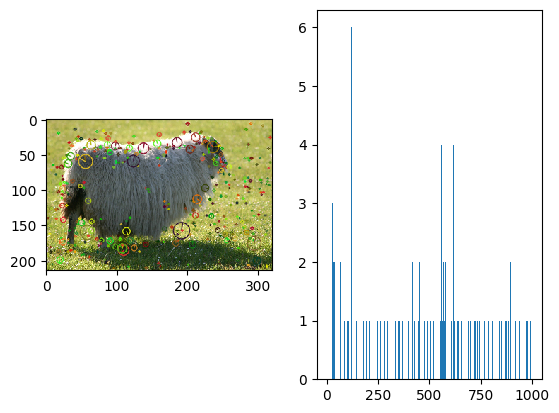

In [31]:
cv2_test_image = cv2_load_image(dir_path, test_images_filenames[0], to_grayscale=True)
indexes, results, keypoints = codebook.get_test_bovw_representation([cv2_test_image])
plot_bovw_images(
    results, indexes, dir_path, test_images_filenames[0:1], keypoints,
    n_classes=codebook.n_clusters, nrows=1
)

### Using `LDA` for Image Understanding
Now that we have our `Codebook` and that we have tested the `KMeans`, we can introduce the `LDA`. We will use the `gensim` implementation.

#### 1. Building and training the `LDA`
At first, we define a convenient function for building and training our LDA over the documents that are stored in our `Codebook` object.

In [32]:
def get_and_train_lda(
    codebook, n_topics=10, doc_topic_prior='auto',
    topic_word_prior='auto', iterations=100, **kwargs
):
  lda = LDA(
      codebook.get_training_bovw_representation(),
      num_topics=n_topics, alpha=doc_topic_prior, eta=topic_word_prior,
      per_word_topics=True, eval_every=1, passes=10, iterations=iterations, **kwargs
  )
  return lda

We will use an `LDA` with $20$ topics and $\alpha = 1, \eta = 1$ for simplicity.

In [33]:
crt = perf_counter()
N_TOPICS = 20
ALPHA = 1
ETA = 1
lda = get_and_train_lda(codebook, N_TOPICS, ALPHA, ETA, iterations=1000, dtype=np.float64)
crt = perf_counter() - crt
print(f"Elapsed time: {crt:.4f} seconds")

Elapsed time: 38.7380 seconds


We can now calculate the empirical distribution of image topics for the training set to have an idea of how topics are distributed and what they may represent. Since both the categories $1$ and $5$ contains animals and cows in particular, we will plot *both* the entire distribution and the distribution excluding category $5$ to make sure that there are no category-related topics that may be "*doubled*" in their frequency being counted for two categories.

[24 18  2 15  1 24  3  7 68  6  1  2  2 22  2 23  1  6  1  4]
[24 18  2 15  1 22  2  3 58  5  1  2  1 14  1 23  1  6  1  3]


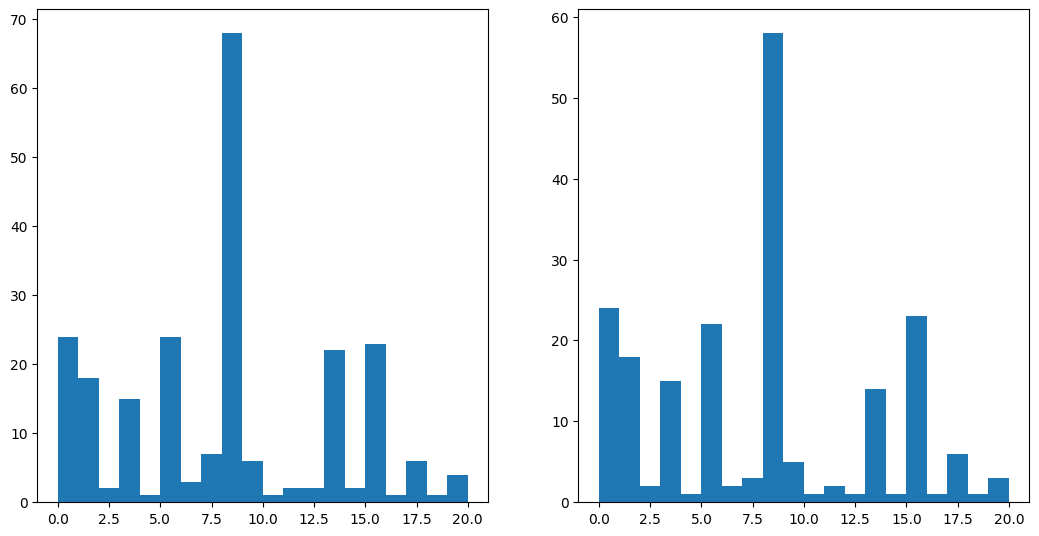

In [35]:
EXCLUDE_CATEGORY = 4 # starting from 0 to 7
IMAGES_PER_CATEGORY = 29 # left out 1 example for testing
START, END = EXCLUDE_CATEGORY*IMAGES_PER_CATEGORY, (EXCLUDE_CATEGORY+1)*IMAGES_PER_CATEGORY

def select(l: list, start=START, end=END, exclude=True):
  if exclude:
    return l[0:start] + l[min(len(l), end):]
  else:
    return l[start:min(len(l), end)]

X = codebook.get_training_bovw_representation()
topic_probs = [Codebook.to_dense(lda.get_document_topics(X[i], minimum_probability=0.0)) for i in range(len(X))]
train_images_topics = draw_samples(np.array(topic_probs), seed=0)
# Now exclude second animals category
X_exclude = select(X)
topic_probs_exclude = select(topic_probs)
train_images_topics_exclude = np.array(select(list(train_images_topics)))

# Show numerically
print(count_occurrencies(train_images_topics.flatten(), 20, repr_type='dense'))
print(count_occurrencies(train_images_topics_exclude.flatten(), 20, repr_type='dense'))

# Show graphically
fig, ax = plt.subplots(1, 2, figsize=(12.8, 6.4))
ax[0].hist(train_images_topics, np.arange(N_TOPICS+1))
ax[1].hist(train_images_topics_exclude, np.arange(N_TOPICS+1))
plt.show()

As we can see we can divide topics in $3$ categories by the number of occurrencies in descending order:

1. $3$ "*dominant*" topics: $7$, $13$ and $17$;
2. $11$ intermediate ones: $\{0, 1, 3, 8, 10, 11, 12, 15, 16, 18, 19\}$;
3. $6$ which occur less often: $\{2, 4, 5, 6, 9, 14\}$.

We can give a first interpretation as the following: the least occurring ones may correspond to category-specific features or rare ones, the intermediate to quite common features and the most frequent one to highly common features that are likely to be shared between different categories.

We can now try to analyze the topic distribution for *each* of the categories, to confirm this first analysis:

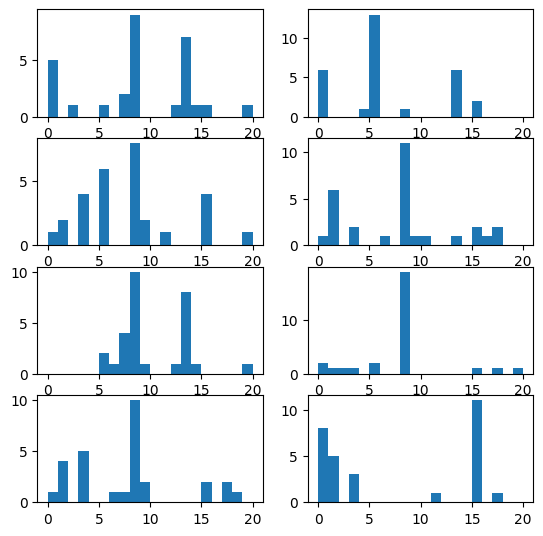

In [36]:
fig, ax = plt.subplots(4, 2, figsize=(6.4, 6.4))
for i in range(8):
  category_images_topics = select(
      train_images_topics, start=i*IMAGES_PER_CATEGORY,
      end=(i+1)*IMAGES_PER_CATEGORY, exclude=False
  )
  ax[i // 2, i % 2].hist(category_images_topics, np.arange(N_TOPICS+1))
plt.show()

**TODO**: Commentare i grafici sopra (ci dicono cosa cercare!)

#### 2. Inference with `LDA`
We can now perform *inference* on new (test) images with our newly trained LDA. In `gensim`, the `get_document_topics()` method with `per_document_topics=True` returns as first argument an array representing the probability distribution $P(\theta|\textbf{w}, \alpha, \beta)$ and as second one a list of the most likely topics for each word, given $\textbf{w}, \alpha, \beta$. We can then use the first one to sample one topic per document and the second one e.g. for assigning to each word its most likely topic.

In [39]:
num_test_images = len(test_images_filenames)
cv2_gray_images_arrays = [
    cv2_load_image(dir_path, test_img_filename, to_grayscale=True)
    for test_img_filename in test_images_filenames
]
test_indexes, test_results, test_keypoints = codebook.get_test_bovw_representation(cv2_gray_images_arrays)

test_topic_and_words_dists = [
    lda.get_document_topics(test_results[i], minimum_probability=0.0,
    per_word_topics=True)[0:2] for i in range(num_test_images)  # discard phi values (third result)
]

test_topic_image_prob_dists = np.array([
    Codebook.to_dense(test_topic_and_words_dists[i][0])
    for i in range(num_test_images)
])
# Draw samples for image topics
test_images_topics = draw_samples(test_topic_image_prob_dists, 1, seed=0)
# Now extract first word topic for each word for each image
test_word_topics_lists = [item[1] for item in test_topic_and_words_dists] # take only the most likely
test_word_topics = []
for i in range(len(test_word_topics_lists)):
  lists = test_word_topics_lists[i]
  #print(lists)
  test_word_topics.append([val[1][0] if len(val[1]) > 0 else -1 for val in lists])

print("Topics per image (words topics): ")
print(
    *[f"{filename} -> {topic} {word_topics}" for filename, topic, word_topics \
      in zip(test_images_filenames, test_images_topics, test_word_topics)],
      sep='\n'
)

Topics per image (words topics): 
1_26_s.bmp -> [8] [13, 8, -1, 13, -1, -1, -1, -1, 7, -1, 13, 13, -1, 8, -1, -1, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 8, -1, -1, 8, -1, 7, -1, 8, -1, -1, 8, 13, -1, -1, 13, -1, 13, -1, 13, -1, 7, 8, -1, 13, -1, -1, 8, -1, 13, -1, 8, 13, -1, -1, -1, -1, 13, 13, 8, 8, 13, 13, -1, -1, -1, -1, -1, 7, -1, -1, -1, -1, -1, -1, -1, 5, -1, -1, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, 8, -1, 8, -1, -1, -1, 13, 7, -1, -1, -1, 13, -1, -1, -1, 8, -1, -1, -1, 13, -1, -1, 8, -1, 8, 13, -1, -1, -1, -1, 8, -1, -1, 8, -1, -1, -1, 13, -1, -1, 13, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, -1, -1, 8, 8, -1, -1, 13, -1, -1, -1, 8, -1, -1, -1, 13, -1, -1, -1, -1, 8, -1, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, -1, 8, 13, -1, -1, -1, -1, -1, -1, -1, 13, 8, -1, -1, -1, -1, -1, -1, -1, 13, -1, -1, -1, -1, 13, 8, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 7, -1, -1, 8, -1, -1, 13, -1, 8, -1, -1, -1, -1, -1, 8, 7, -1, -1, -1, -1, 13, -1, -1, -1, 8, -1, 13

Now that we have extracted image and word (SIFT descriptors) topics, we need to map them to the corresponding keypoints to get a representation of what the model has extracted from data.

In [61]:
def assign_topics_to_words(word_topics: list[list[int]], keypoints: list[list[cv2.KeyPoint]]):
  topic_keypoints, topic_labels = [], []
  for image_word_topics, image_keypoints in zip(word_topics, keypoints):
    current_keypoints = [
      cv2.KeyPoint(
          *keypoint.pt, size=keypoint.size, angle=-1, response=keypoint.response,
          octave=keypoint.octave, class_id=image_word_topics[keypoint.class_id]
      ) for keypoint in image_keypoints
    ]
    current_labels = [keypoint.class_id for keypoint in current_keypoints]
    topic_keypoints.append(current_keypoints)
    topic_labels.append(current_labels)
  return topic_keypoints, topic_labels

In [51]:
def count_word_topics_occurrencies(word_topics: list[list[int]], word_occurrencies: list[list[int]], num_topics):
  results = []
  for image_word_topics, image_word_occurrencies in zip(word_topics, word_occurrencies):
    current = num_topics * [0]
    for word_topic, word_occurrencies in zip(image_word_topics, image_word_occurrencies):
      if word_topic > -1:
        current[word_topic] += word_occurrencies[1]
    results.append(current)
  return results

432 - Topic occurrencies: [0, 14, 0, 0, 0, 18, 0, 53, 166, 0, 0, 0, 0, 181, 0, 0, 0, 0, 0, 0]
587 - Topic occurrencies: [15, 0, 0, 0, 0, 572, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
508 - Topic occurrencies: [0, 25, 0, 361, 0, 0, 0, 0, 120, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0]
294 - Topic occurrencies: [0, 171, 0, 12, 0, 0, 0, 0, 111, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
499 - Topic occurrencies: [0, 0, 0, 0, 0, 47, 0, 0, 337, 0, 0, 0, 0, 115, 0, 0, 0, 0, 0, 0]
564 - Topic occurrencies: [34, 19, 0, 2, 0, 12, 0, 0, 137, 0, 0, 0, 0, 246, 0, 114, 0, 0, 0, 0]
412 - Topic occurrencies: [7, 87, 0, 1, 0, 29, 0, 0, 288, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
685 - Topic occurrencies: [88, 48, 0, 10, 0, 0, 0, 0, 242, 0, 0, 0, 0, 0, 0, 297, 0, 0, 0, 0]


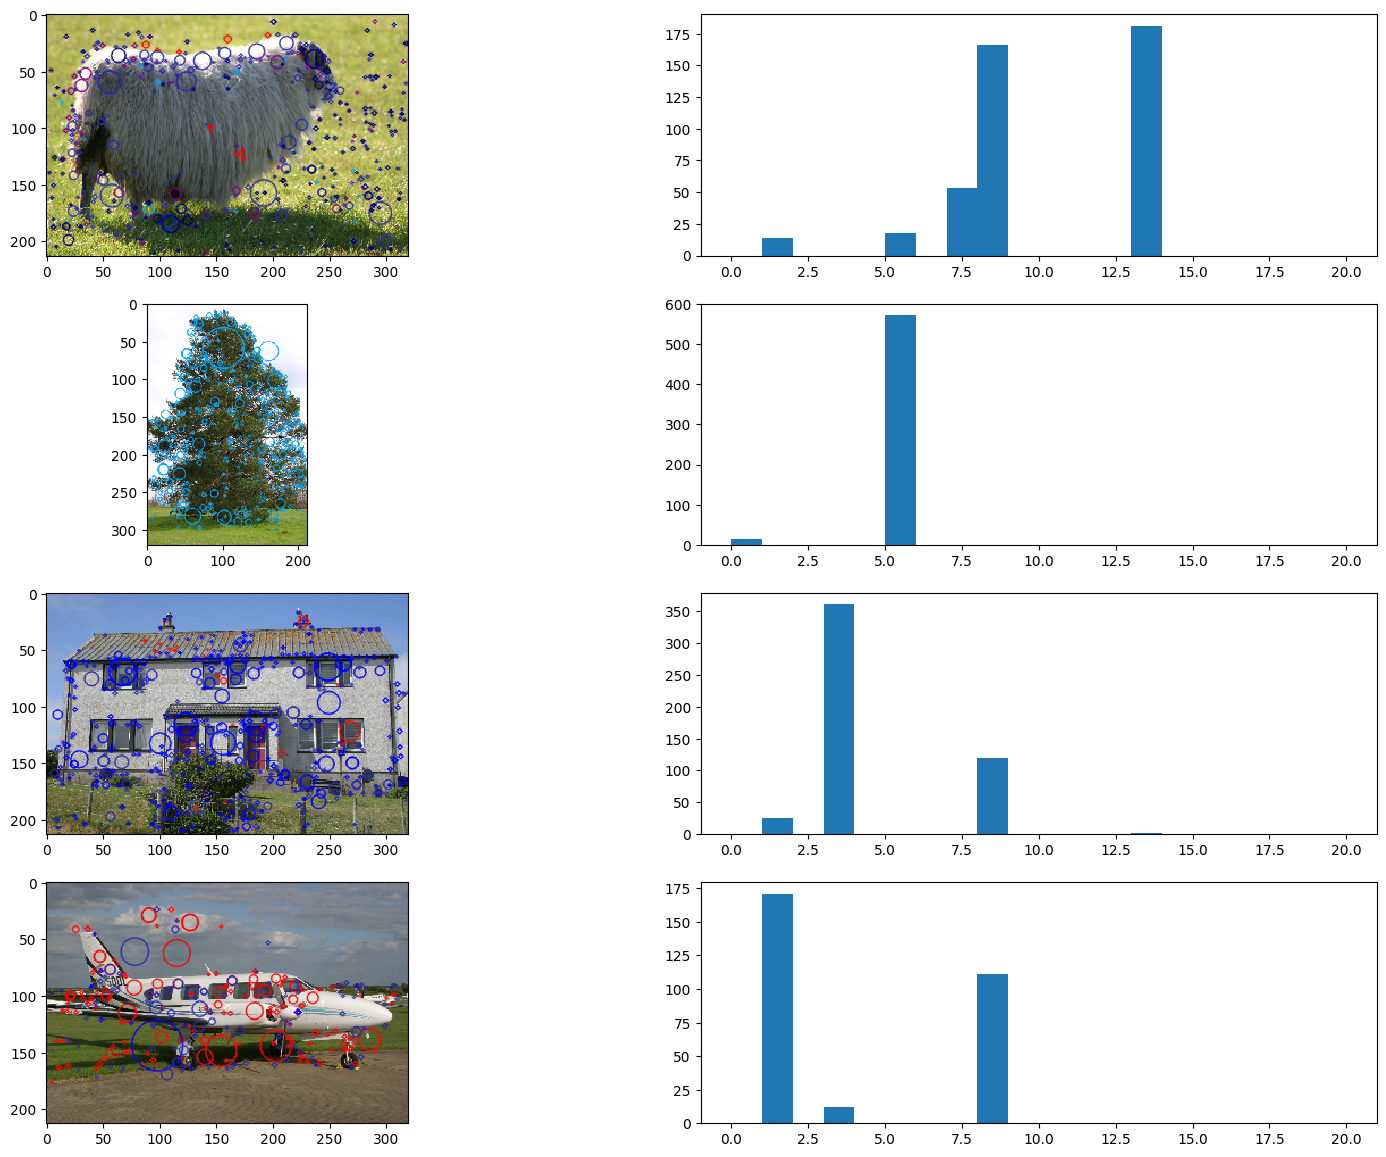

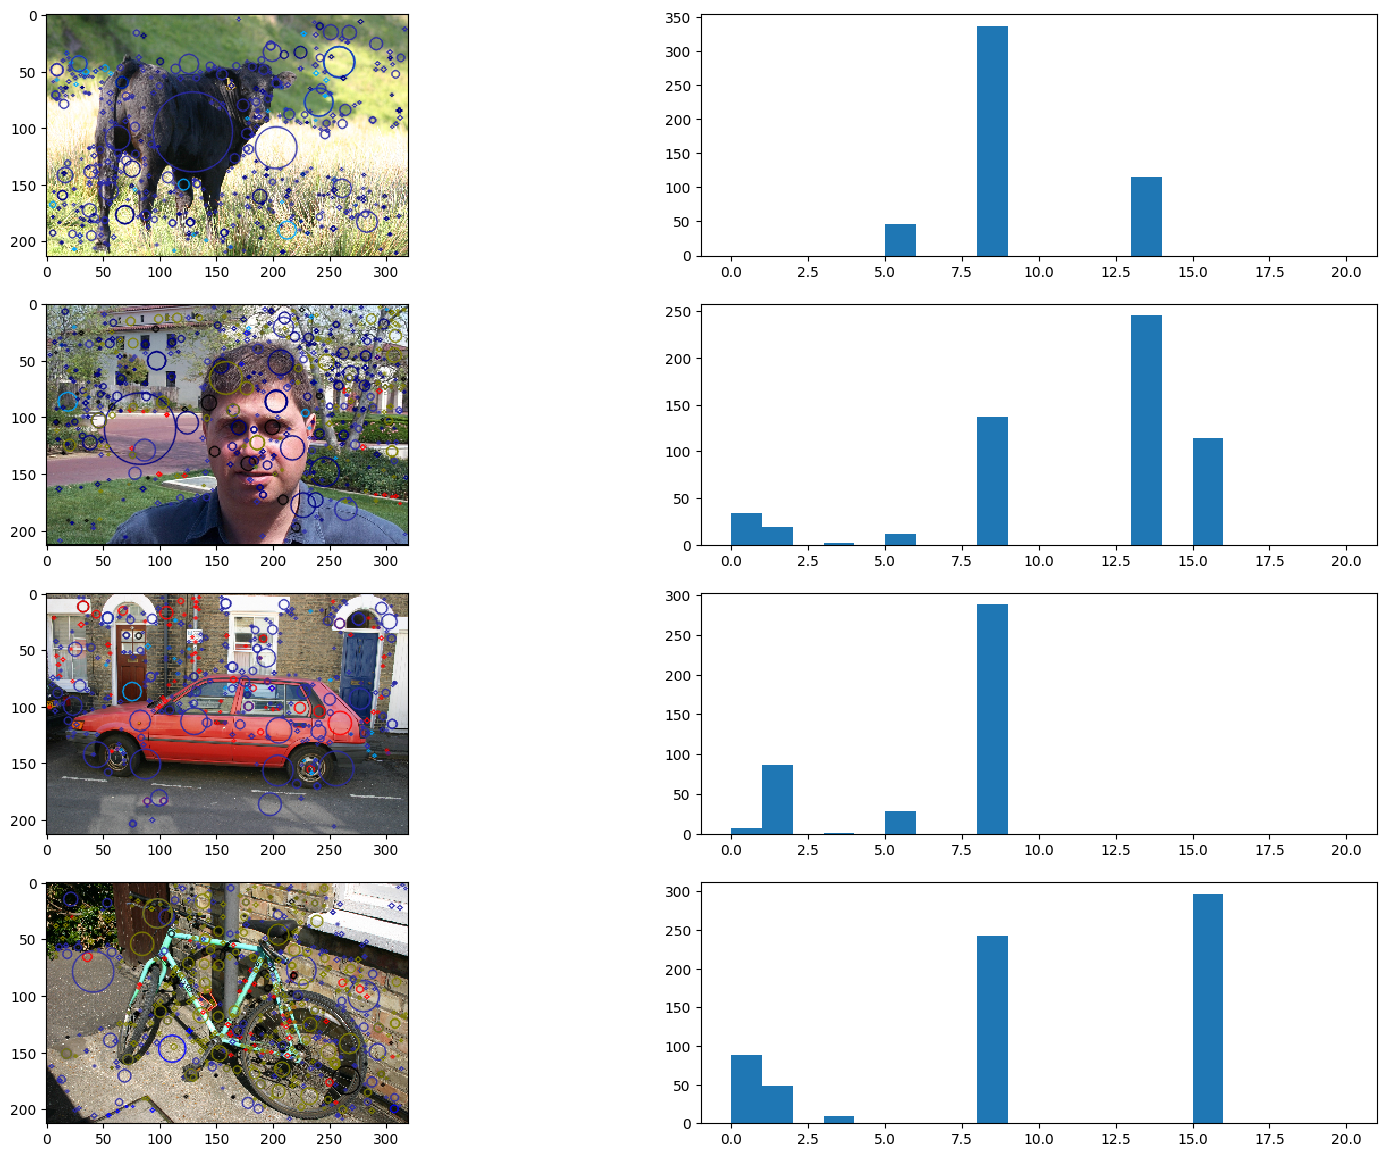

In [73]:
test_topic_keypoints, test_topic_labels = assign_topics_to_words(test_word_topics, test_keypoints)
word_topics_occurrencies = count_word_topics_occurrencies(test_word_topics, test_results, N_TOPICS)
for topics_occurrencies, topic_keypoints in zip(word_topics_occurrencies, test_keypoints):
  print(f"{len(topic_keypoints)} - Topic occurrencies: {topics_occurrencies}")
for j in range(2):
  plot_bovw_images(
      test_results[4*j:4*(j+1)], test_topic_labels[4*j:4*(j+1)], dir_path, test_images_filenames[4*j:4*(j+1)],
      test_topic_keypoints[4*j:4*(j+1)], N_TOPICS, 4, figsize=(19.2, 14.4), verbose=False,
  )

## Experiments
In this section we will perform several experiments for testing behaviour of our LDA model under different hyperparameter values ($\alpha$, $\eta$, number of topics $T$, number of clusters $K$).
In the previous example, we have seen that using a high number of clusters $\left(K = 1000\right)$ and of topics $\left(T = 20\right)$ seems to favor a few "dominant" clusters and topics, and we want to extend this analysis to less topics and clusters.

In particular, we will perform an experiment for each of these combinations:

- $T \in \{8, 10, 20\}$;
- $K \in \{100, 500, 1000\}$;

for a total of $9$ experiments.

### 1. Experiments

### 2. Analysis of the results

## Conclusions